# Redspots Environment

## Environment Description

A simple gridworld with white (safe) spots, green (rewarding) spots, and red (undesirable/dangerous) spots.

## Goal

Have an agent map the environment and infer the best way to avoid red spots and get to the green spot.

# Setup

## Imports

In [771]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

import seaborn as sns

import pymdp
from pymdp import utils

## Auxilary Functions

In [772]:
def plot_grid(grid_locations, num_x = 3, num_y = 3 ):
    """
    Plots the spatial coordinates of GridWorld as a heatmap, with each (X, Y) coordinate 
    labeled with its linear index (its `state id`)
    """

    grid_heatmap = np.zeros((num_x, num_y))
    for linear_idx, location in enumerate(grid_locations):
      y, x = location
      grid_heatmap[y, x] = linear_idx
    sns.set(font_scale=1.5)
    sns.heatmap(grid_heatmap, annot=True, cbar = False, fmt='.0f', cmap='crest')

def plot_likelihood(matrix, title_str = "Likelihood distribution (A)"):
    """
    Plots a 2-D likelihood matrix as a heatmap
    """

    if not np.isclose(matrix.sum(axis=0), 1.0).all():
      raise ValueError("Distribution not column-normalized! Please normalize (ensure matrix.sum(axis=0) == 1.0 for all columns)")
    
    fig = plt.figure(figsize = (6,6))
    ax = sns.heatmap(matrix, cmap = 'gray', cbar = False, vmin = 0.0, vmax = 1.0)
    plt.title(title_str)
    plt.show()


def plot_beliefs(belief_dist, title_str=""):
    """
    Plot a categorical distribution or belief distribution, stored in the 1-D numpy vector `belief_dist`
    """

    if not np.isclose(belief_dist.sum(), 1.0):
      raise ValueError("Distribution not normalized! Please normalize")

    plt.grid(zorder=0)
    plt.bar(range(belief_dist.shape[0]), belief_dist, color='r', zorder=3)
    plt.xticks(range(belief_dist.shape[0]))
    plt.title(title_str)
    plt.show()

In [773]:
def add_noise(matrix, noise_level=0.1):
    """
    Add noise to transition matrix while preserving normalization
    
    Args:
        A: Original transition matrix
        noise_level: Amount of noise to add (0-1)
    """
    # Generate random noise
    noise = np.random.uniform(-noise_level, noise_level, size=matrix.shape)

    print(noise) 
    
    # Add noise to matrix
    noisy_matrix = matrix + noise
    
    # Ensure non-negative
    noisy_matrix = np.maximum(noisy_matrix, 0.0)
    
    # Normalize columns to sum to 1
    noisy_matrix = noisy_matrix / noisy_matrix.sum(axis=0, keepdims=True)
    
    return noisy_matrix

## Parameters

### Grid

In [774]:
# grid_dimensions
grid_dims = [7,5]

# list of grid positiions
grid_locations = []
for i in range(7):
    for j in range(5):
        grid_locations.append((i,j))

In [775]:
redspots = [(1,2), (3,2), (4,4), (6,1)]

In [776]:
# start point
agent_pos = (0,0)

# end goal
goal_location = (6,4)

## Generative Model

### States & Observations

s1 = current location \
s2 = attribute of current location

o1 = observed current location \
o2 = color of current location

In [777]:
# s1 is already defined = grid_locations

# s2
safety_level_state = ['SAFE', 'DANGER', 'REWARDING']

# list of # of possibillities for states
num_states = [len(grid_locations), len(safety_level_state)] # location


In [778]:
# o1 is already defined = grid_locatioons

# o2
color = ['WHITE', 'RED', 'GREEN']

# list of # of possibilities for observations
num_obs = [len(grid_locations), len(color)]

# Generative Model

## Rule-based Matrix

In [779]:
rule_matrix = np.zeros((len(grid_locations), len(safety_level_state)))

# Rule-based assignment
for loc in range(num_states[0]):
    # Example: Assume all locations have [SAFE: 0.7, DANGER: 0.2, REWARDING: 0.1]
    rule_matrix[loc] = np.array([0.33, 0.33, 0.33])
    rule_matrix[loc] /= rule_matrix[loc].sum()

    # Normalize each location's attribute distribution (ensure sum = 1)

# rule_matrix

In [780]:
# red, green, white, one-hot encoded
# rule_matrix -> white, red, green -> safe, dangerous, rewarding

def update_rule_matrix(grid_locations, safety_level_state, color_observation):

    rule_matrix = np.zeros((len(grid_locations), len(safety_level_state)))

    # Rule-based assignment
    for i in range(num_states[0]):

        # update rule_matrix[i] based on color_observation[i]

        if color_observation[0] == 1: # if it's red
            rule_matrix[i] = [0.1, 0.8, 0.1]
        elif color_observation[1] == 1: # if it's green
            rule_matrix[i] = [0.1, 0.1, 0.8]
        elif color_observation[2] == 1: # if it's white
            rule_matrix[i] = [0.8, 0.1, 0.1]
        else:
            rule_matrix[i] = np.array([0.33, 0.33, 0.33])

        rule_matrix[i] /= rule_matrix[loc].sum()

        # Normalize each location's attribute distribution (ensure sum = 1)

    return rule_matrix

In [781]:
# def update_A_1(rule_matrix):
#     A[1] = 

## A Matrix

### Location observation modality: A[0]

In [782]:
# Define A Matrix
A = utils.obj_array_zeros([[35,35, 3], [3,35,3]])
print(A.shape)


(2,)


In [783]:
# Create a new array for the location observation modality with shape [35,35,3]
A[0] = np.zeros((35, 35, 3))

# Fill in the observation mapping for each safety level
for safety_level in range(3):
    A[0][:,:,safety_level] = np.eye(35)  # Copy the identity matrix for each safety level

# Verify the shape and normalization
print("New A[0] shape:", A[0].shape)
print("Column sums:", A[0].sum(axis=0).sum(axis=1))  # Should be all 1's

New A[0] shape: (35, 35, 3)
Column sums: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]


### Color observation modality: A[1]

In [784]:
# Map safety levels to indices
safety_level_to_index = {state: i for i, state in enumerate(safety_level_state)}  # {'SAFE': 0, 'DANGER': 1, 'REWARDING': 2}

# Probabilities for each color given the safety level (in correct heatmap order: RED, GREEN, WHITE)
probabilities = {
    "SAFE": [0.7, 0.1, 0.2],        # ['WHITE', 'RED', 'GREEN']
    "DANGER": [0.1, 0.85, 0.05],      # ['WHITE', 'RED', 'GREEN']
    "REWARDING": [0.15, 0.05, 0.8]    # ['WHITE', 'RED', 'GREEN']
}

In [785]:
# Populate A[1]
for safety_level, probs in probabilities.items():
    safety_idx = safety_level_to_index[safety_level]
    for loc in range(len(grid_locations)):  # Iterate over grid locations
        for color_idx, prob in enumerate(probs):  # Iterate over colors (RED, GREEN, WHITE)
            A[1][color_idx, loc, safety_idx] = prob  # Assign probabilities

### Add Noise

In [786]:
# Add noise to each modality separately
for modality in range(len(A)):
    A[modality] = add_noise(A[modality], noise_level=0)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0.

### Plot Each Matrix

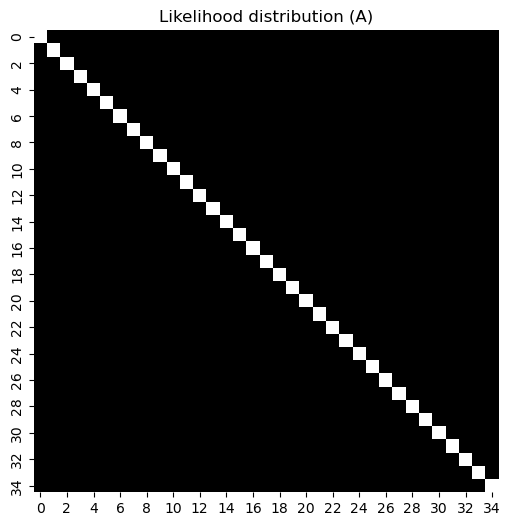

In [787]:
plot_likelihood((A[0][:,:,0]))

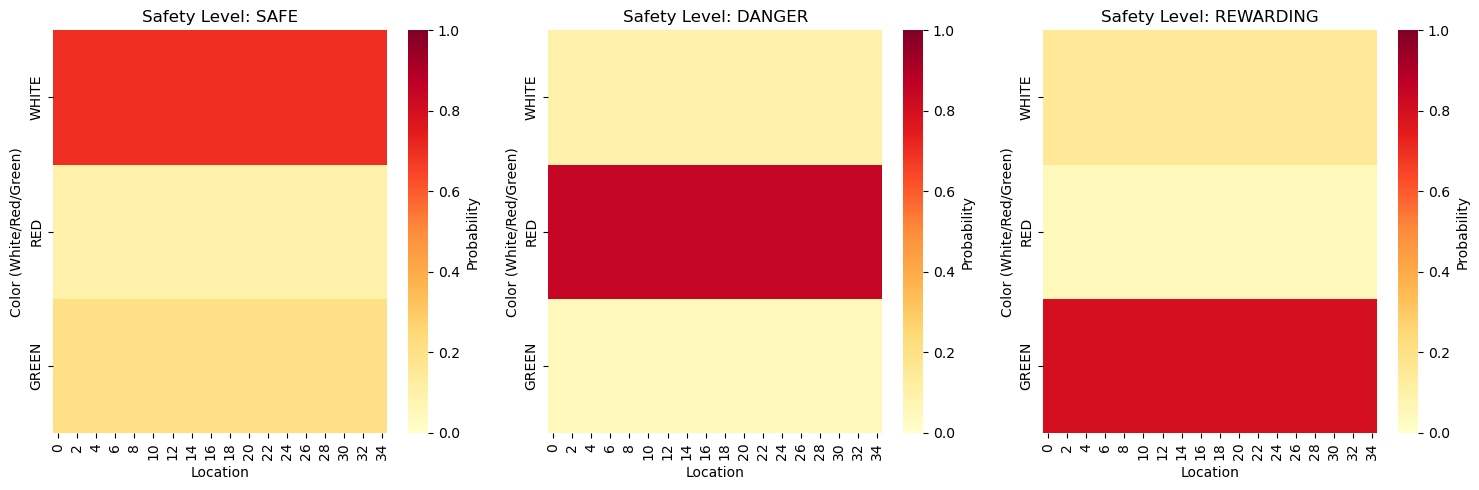

In [788]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
safety_labels = ['SAFE', 'DANGER', 'REWARDING']

# Plot each safety level separately
for i in range(3):  # 3 safety levels
    # Extract the matrix for this safety level
    safety_matrix = A[1][:, :, i]  # shape: (3 colors, 35 locations)
    
    # Create heatmap
    sns.heatmap(safety_matrix, 
                ax=axes[i],
                cmap='YlOrRd',
                vmin=0,
                vmax=1,
                cbar_kws={'label': 'Probability'})
    
    # Customize the plot
    axes[i].set_title(f'Safety Level: {safety_labels[i]}')
    axes[i].set_xlabel('Location')
    axes[i].set_ylabel('Color (White/Red/Green)')
    axes[i].set_yticks([0.5, 1.5, 2.5])
    axes[i].set_yticklabels(['WHITE', 'RED', 'GREEN'])

plt.tight_layout()
plt.show()

## B Matrix

### Define Shape

In [789]:
num_controls = [5, 1]
B_f_shapes = [ [ns, ns, num_controls[f]] for f, ns in enumerate(num_states)]
B = utils.obj_array_zeros(B_f_shapes)
B_f_shapes


[[35, 35, 5], [3, 3, 1]]

### B[0] - Control Factor - Location Transitions

In [790]:
grid_dims

[7, 5]

In [791]:
actions = ["UP", "DOWN", "LEFT", "RIGHT", "STAY"]

In [792]:
for action_id, action_label in enumerate(actions):
  
    for curr_state, (x, y) in enumerate(grid_locations):
        
        # Calculate next position based on action
        if action_label == "UP":
            next_y = max(0, y - 1)        # Move up (decrease y)
            next_x = x
        elif action_label == "DOWN":
            next_y = min(grid_dims[1]-1, y + 1)  # Move down (increase y)
            next_x = x
        elif action_label == "LEFT":
            next_x = max(0, x - 1)        # Move left (decrease x)
            next_y = y
        elif action_label == "RIGHT":
            next_x = min(grid_dims[0]-1, x + 1)  # Move right (increase x)
            next_y = y
        else:  # STAY
            next_x = x
            next_y = y
        
        # Get the state index for the next position
        next_state = grid_locations.index((next_x, next_y))
        
        # Set transition probability to 1.0
        B[0][next_state, curr_state, action_id] = 1.0

### B[1] - Non-Control Factor - Identity Matrix

In [793]:
# Initialize safety level transition matrix (no changes for safety levels)
B[1][:,:,0] = np.eye(3)  # Identity matrix for safety level transitions

### Normalization

In [794]:
# Normalize B matrix columns for each action
for action_id in range(len(actions)):
    # Get slice for current action
    B_action = B[0][..., action_id]
    
    # Replace zero columns with ones in appropriate positions
    zero_cols = (B_action.sum(axis=0) == 0)
    for col in range(B_action.shape[1]):
        if zero_cols[col]:
            # Stay in the same state if no transition is defined
            B_action[col, col] = 1.0
    
    # Normalize columns
    column_sums = B_action.sum(axis=0)
    B[0][..., action_id] = B_action / column_sums[None, :]

# Verify normalization
for action_id in range(len(actions)):
    assert np.allclose(B[0][..., action_id].sum(axis=0), 1.0), f"Action {actions[action_id]} not normalized"

## C Vectors (prior preferences)

### Initialize

In [795]:
C = utils.obj_array_zeros(num_obs)  # Initialize C array with shape matching num_obs
print(C.shape)


(2,)


### C[0] - Preference for location observations - N/A

In [796]:
# Set preferences for state observations (location)
C[0] = np.zeros(len(grid_locations))
print(C[0])
C[0][grid_locations.index((3,3))] = 1

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


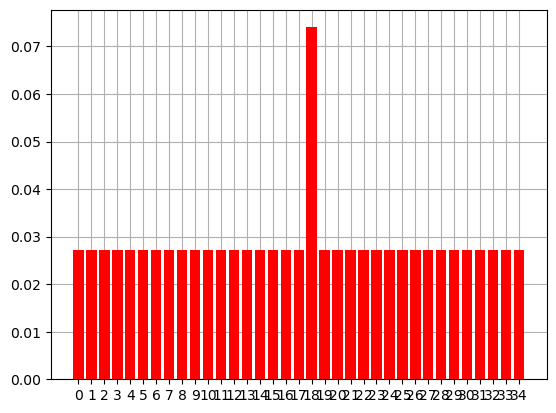

In [797]:
plot_beliefs(softmax(C[0]))

### C[1] - Preference for color observations

In [798]:
# white, red, green <- order it's encoded in

In [799]:
# Set preferences for color observations
C[1] = np.zeros((3,))
C[1][0] = -0.1
C[1][1] = -1
C[1][2] = 1.1

print(C[1])


[-0.1 -1.   1.1]


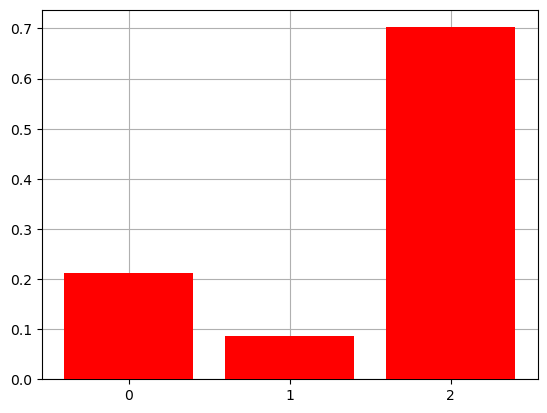

In [800]:
plot_beliefs(softmax(C[1]))

## D Vectors: Prior beliefs about hidden states

### Initialize

In [801]:
# Shape
num_states

[35, 3]

In [802]:
D = utils.obj_array_uniform(num_states)

### D[0] - Belief About Current Location

In [803]:
# Define prior belief about agent's location (same as before)
D[0] = np.zeros(num_states[0])  # Shape (35,)
D[0][grid_locations.index(agent_pos)] = 1.0  # One-hot encoding for location

print("D[0] shape (Location prior):", D[0].shape)  # (35,)
D[0]

D[0] shape (Location prior): (35,)


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [804]:
# # Initialize uniform distribution over locations
# D[0] = np.ones(num_states[0]) / num_states[0]  # Create normalized uniform distribution over all locations

# D[0]

### D[1] - Belief About Attribute of Current Location

In [805]:
D[1] = np.zeros(num_states[1]) # white red green / safe, dangerous, rewarding
D[1][0] = 1.0 # set belief to safe

print("D[1] shape (Attribute prior for all locations):", D[1].shape)  # (35, 3)
D[1]

D[1] shape (Attribute prior for all locations): (3,)


array([1., 0., 0.])

In [806]:
# D[1] = np.ones(num_states[1]) / num_states[1]  # Create normalized uniform distribution over all locations

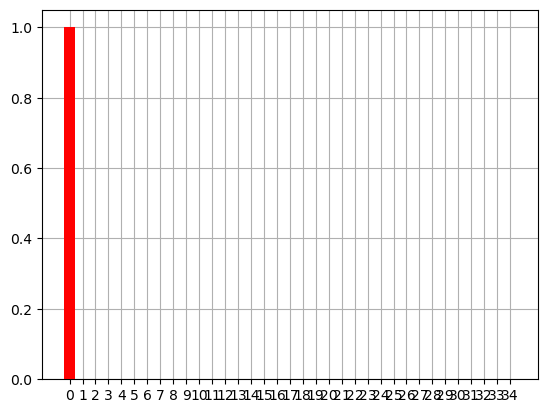

In [807]:
plot_beliefs(D[0])

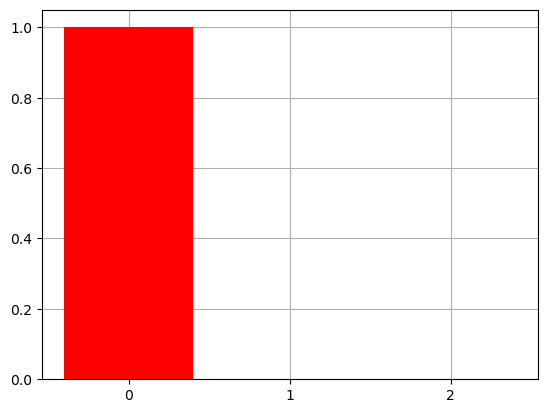

In [808]:
plot_beliefs(D[1])

# Generative Process

In [809]:
def update_vision(current_location, grid_dims, distance):
    """
    Update the agent's field of vision based on the current location and distance
    Returns a list of all grid positions within the vision range
    
    Args:
        current_location (tuple): Current (x,y) position of the agent
        grid_dims (list): Dimensions of the grid [width, height]
        distance (int): Vision range/distance
        
    Returns:
        list: List of (x,y) tuples representing visible grid positions
    """
    x, y = current_location
    x_min = max(0, x - distance)
    x_max = min(grid_dims[0], x + distance + 1)
    y_min = max(0, y - distance)
    y_max = min(grid_dims[1], y + distance + 1)
    
    visible_locations = []
    for y_pos in range(y_min, y_max):
        for x_pos in range(x_min, x_max):
            visible_locations.append((x_pos, y_pos))
            
    return visible_locations

In [810]:
X, Y = 0, 0

class GridWorldEnv():

    def __init__(self, starting_loc = (0, 0), red1_loc = (1, 2), red2_loc = (3,2), red3_loc = (4,4), red4_loc = (6, 1), goal = (6 ,4)):
        self.init_loc = starting_loc
        self.current_location = self.init_loc
        Y, X = self.current_location

        self.red1_loc = red1_loc
        self.red2_loc = red2_loc
        self.red3_loc = red3_loc
        self.red4_loc = red4_loc
        self.redspots = [self.red1_loc, self.red2_loc, self.red3_loc, self.red4_loc]

        self.goal = goal

        self.red_obs = ['Null']
        self.green_obs = 'Null'
        self.white_obs = ['Null']

        self.agent_reward = 0 # not observation or state
        
        print(f"Starting location is {self.init_loc} | Red spot locations are {self.red1_loc, self.red2_loc, self.red3_loc, self.red4_loc} | Goal is {self.goal}")
    
    def step(self, action_label):

        X, Y = self.current_location


        if action_label == "UP": 
          if Y < grid_dims[0] - 1: Y_new = Y + 1
          else: Y_new = Y
          X_new = X

        elif action_label == "DOWN": 
        
          if Y > 0: Y_new = Y - 1
          else: Y_new = Y
          X_new = X      

        elif action_label == "LEFT": 
          
          if X > 0: X_new = X - 1
          else: X_new = X
          Y_new = Y

        elif action_label == "RIGHT": 
          
          if X < grid_dims[1] - 1: X_new = X + 1
          else: X_new = X
          Y_new = Y

        elif action_label == "STAY":
          Y_new, X_new = Y, X
        
        X, Y = X_new, Y_new
        self.current_location = (X_new, Y_new) # store the new grid location
        print(f" self.current_location: {self.current_location}")
        self.vision = update_vision(self.current_location, grid_dims, 6)

        self.loc_obs = self.current_location # agent directly observes its position in grid

        for spot in self.vision:
            if spot in self.redspots:
                if 'Null' in self.red_obs:
                    self.red_obs = [spot]
                else:
                    self.red_obs.append(spot)
            elif spot == self.goal:
                self.green_obs = spot
            else:
                if 'Null' in self.white_obs:
                    self.white_obs = [spot]
                else:
                    self.white_obs.append(spot)


        if self.current_location in self.redspots:
            self.agent_reward -= 5
            if 'Null' in self.red_obs:
                self.red_obs = [self.current_location]
            else:
                self.red_obs.append(self.current_location)
        elif self.current_location == self.goal:
            self.agent_reward += 20
            self.green_obs = self.current_location
        else:
            if 'Null' in self.white_obs:
                self.white_obs = [self.current_location]
            else:
                self.white_obs.append(self.current_location)
        
        return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward
    
    def reset(self):
        self.current_location = self.init_loc
        print(f'Re-initialized location to {self.init_loc}')
        self.loc_obs = self.current_location
        self.green_obs, self.white_obs, self.red_obs, self.agent_reward = 'Null', ['Null'], ['Null'], 0

        return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward

In [811]:
class GridWorldEnv():
    def __init__(self, starting_loc=(0, 0), red1_loc=(2, 1), red2_loc=(2, 3), 
                 red3_loc=(4, 4), red4_loc=(1, 6), goal=(4, 6)):
        # Initialize coordinates
        self.x, self.y = starting_loc
        self.init_loc = starting_loc
        self.current_location = (self.x, self.y)
        
        self.red1_loc = red1_loc
        self.red2_loc = red2_loc
        self.red3_loc = red3_loc
        self.red4_loc = red4_loc
        self.redspots = [self.red1_loc, self.red2_loc, self.red3_loc, self.red4_loc]

        self.goal = goal

        self.red_obs = ['Null']
        self.green_obs = 'Null'
        self.white_obs = ['Null']

        self.agent_reward = 0
        
        print(f"Starting location is {self.current_location} | Red spot locations are {self.red1_loc, self.red2_loc, self.red3_loc, self.red4_loc} | Goal is {self.goal}")
    
    def step(self, action_label):
        if action_label == "UP": 
            self.y = max(0, self.y - 1)  # Move up (decrease y)
            
        elif action_label == "DOWN": 
            self.y = min(grid_dims[1] - 1, self.y + 1)  # Move down (increase y)

        elif action_label == "LEFT": 
            self.x = max(0, self.x - 1)  # Move left (decrease x)

        elif action_label == "RIGHT": 
            self.x = min(grid_dims[0] - 1, self.x + 1)  # Move right (increase x)

        # Update current_location tuple after movement
        self.current_location = (self.x, self.y)
        print(f"self.current_location: {self.current_location}")
        
        # Update vision with current coordinates
        self.vision = update_vision(self.current_location, grid_dims, 6)

        self.loc_obs = self.current_location

        # Reset observations at each step
        self.red_obs = ['Null']
        self.white_obs = ['Null']
        self.green_obs = 'Null'

        # Update observations based on vision
        for spot in self.vision:
            if spot in self.redspots:
                if 'Null' in self.red_obs:
                    self.red_obs = [spot]
                else:
                    self.red_obs.append(spot)
            elif spot == self.goal:
                self.green_obs = spot
            else:
                if 'Null' in self.white_obs:
                    self.white_obs = [spot]
                else:
                    self.white_obs.append(spot)

        # Update rewards and observations based on current location
        if self.current_location in self.redspots:
            self.agent_reward -= 5
            if 'Null' in self.red_obs:
                self.red_obs = [self.current_location]
            else:
                self.red_obs.append(self.current_location)
        elif self.current_location == self.goal:
            self.agent_reward += 20
            self.green_obs = self.current_location
        else:
            if 'Null' in self.white_obs:
                self.white_obs = [self.current_location]
            else:
                self.white_obs.append(self.current_location)
        
        return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward
    
    def reset(self):
        self.x, self.y = self.init_loc
        self.current_location = (self.x, self.y)
        print(f'Re-initialized location to {self.current_location}')
        self.loc_obs = self.current_location
        self.green_obs, self.white_obs, self.red_obs, self.agent_reward = 'Null', ['Null'], ['Null'], 0

        return self.loc_obs, self.green_obs, self.white_obs, self.red_obs, self.agent_reward

# Active Inference

In [812]:
from pymdp.agent import Agent

In [813]:
my_agent = Agent(A=A, B=B, C=C, D=D, policy_len=6)

my_env = GridWorldEnv(starting_loc = (0, 0), red1_loc = (1, 2), red2_loc = (3,2), red3_loc = (4,4), red4_loc = (6, 1), goal = (6 ,4))

loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.reset()
loc_obs, green_obs, white_obs, red_obs, agent_reward

Starting location is (0, 0) | Red spot locations are ((1, 2), (3, 2), (4, 4), (6, 1)) | Goal is (6, 4)
Re-initialized location to (0, 0)


((0, 0), 'Null', ['Null'], ['Null'], 0)

In [814]:
loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.step('STAY')

self.current_location: (0, 0)


In [815]:
loc_obs, green_obs, white_obs, red_obs, agent_reward

((0, 0),
 (6, 4),
 [(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0),
  (6, 0),
  (0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (0, 2),
  (2, 2),
  (4, 2),
  (5, 2),
  (6, 2),
  (0, 3),
  (1, 3),
  (2, 3),
  (3, 3),
  (4, 3),
  (5, 3),
  (6, 3),
  (0, 4),
  (1, 4),
  (2, 4),
  (3, 4),
  (5, 4),
  (0, 0)],
 [(6, 1), (1, 2), (3, 2), (4, 4)],
 0)

## Create Observation

In [816]:
loc_obs

(0, 0)

In [817]:
grid_locations

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4),
 (5, 0),
 (5, 1),
 (5, 2),
 (5, 3),
 (5, 4),
 (6, 0),
 (6, 1),
 (6, 2),
 (6, 3),
 (6, 4)]

In [818]:
def create_color_observation(position, red_obs, green_obs, white_obs):

    if red_obs != ['Null']:
        if position in red_obs: return 1  # RED
    if green_obs == position: return 2 # GREEN
    elif white_obs != ['Null']:
        if position in white_obs: return 0 # WHITE
    
    return 'Null'

In [819]:
# obs = [grid_locations.index(loc_obs), create_color_observation(loc_obs, red_obs, green_obs, white_obs)]

## Loop

In [820]:
my_agent.qs[0], my_agent.qs[1]

(array([0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143,
        0.02857143, 0.02857143, 0.02857143, 0.02857143, 0.02857143]),
 array([0.33333333, 0.33333333, 0.33333333]))

In [821]:
obs = [grid_locations.index(loc_obs), create_color_observation(loc_obs, red_obs, green_obs, white_obs)]


[0, 0]


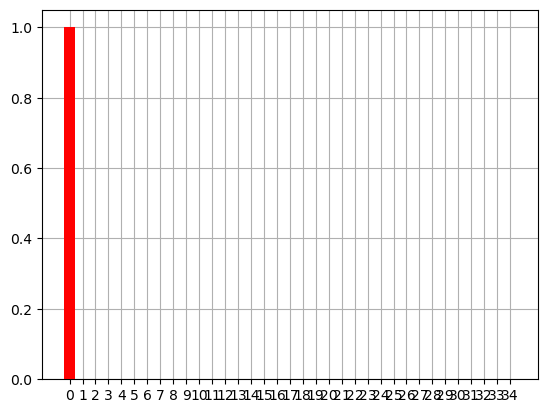

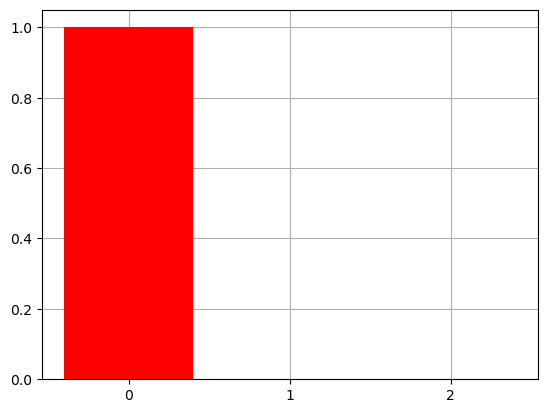

Action at time 0: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 0: (0, 0)
Reward at time 0: 0
[0, 0]


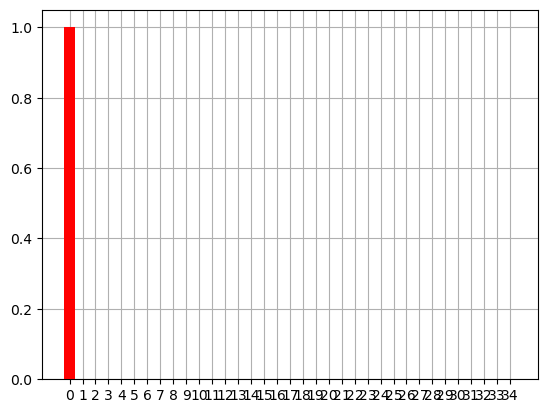

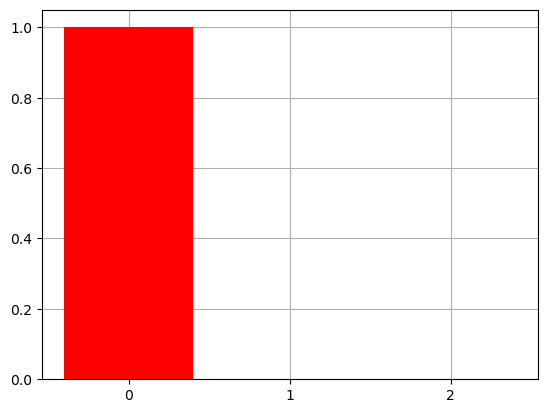

Action at time 1: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 1: (0, 0)
Reward at time 1: 0
[0, 0]


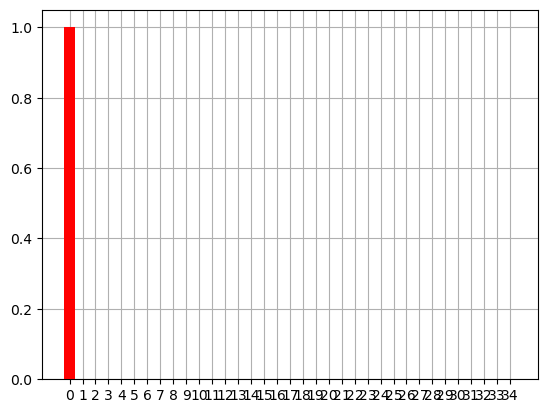

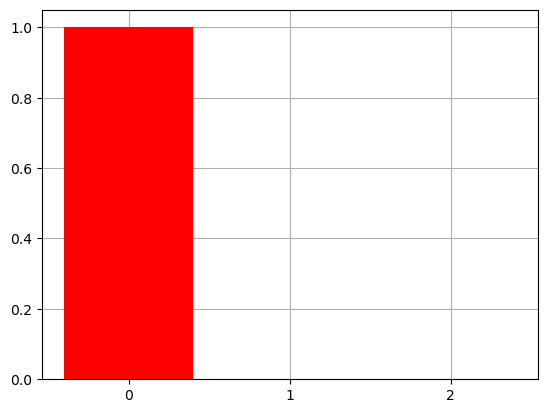

Action at time 2: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 2: (0, 0)
Reward at time 2: 0
[0, 0]


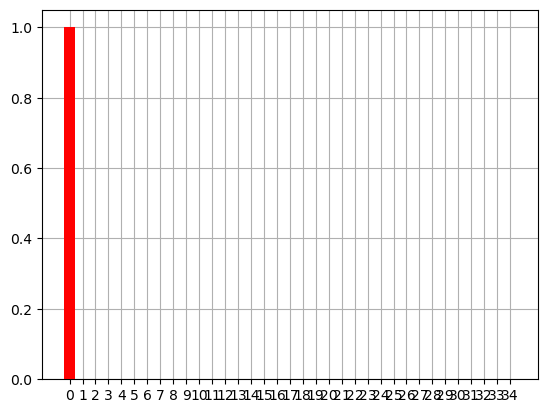

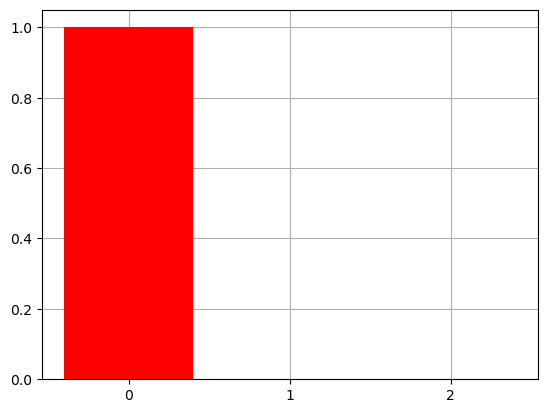

Action at time 3: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 3: (0, 0)
Reward at time 3: 0
[0, 0]


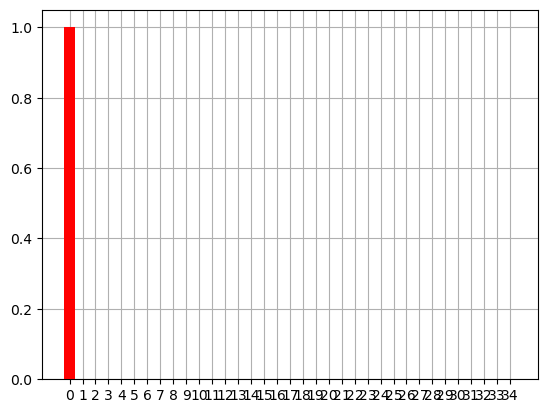

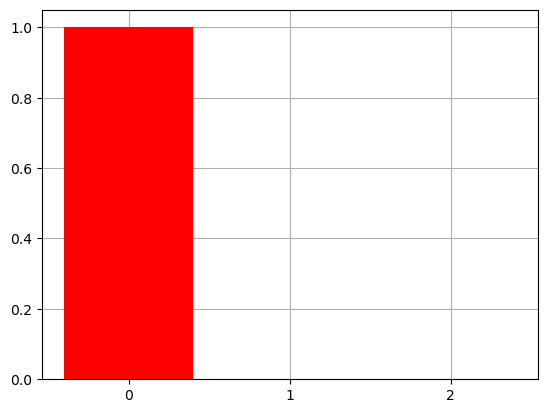

Action at time 4: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 4: (0, 0)
Reward at time 4: 0
[0, 0]


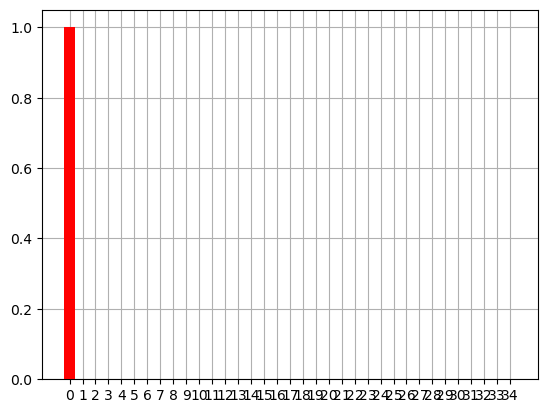

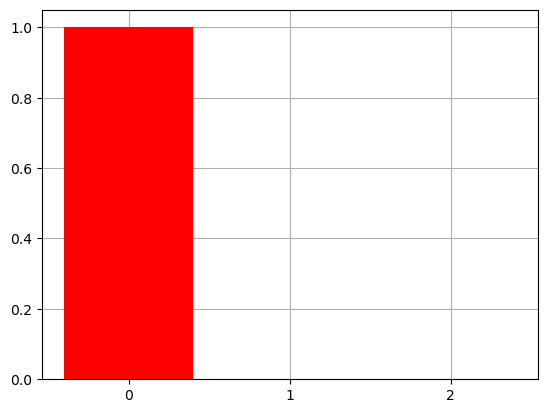

Action at time 5: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 5: (0, 0)
Reward at time 5: 0
[0, 0]


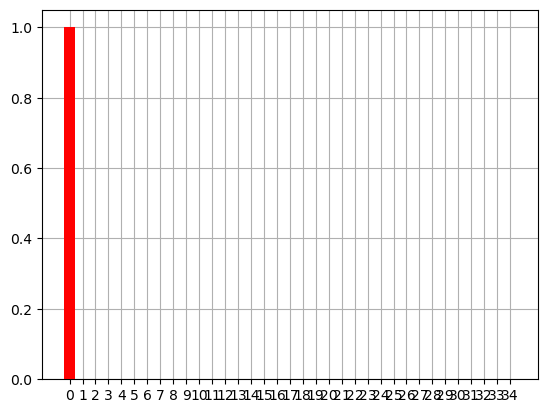

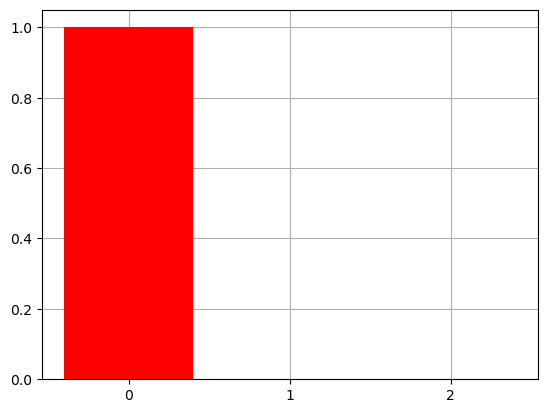

Action at time 6: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 6: (0, 0)
Reward at time 6: 0
[0, 0]


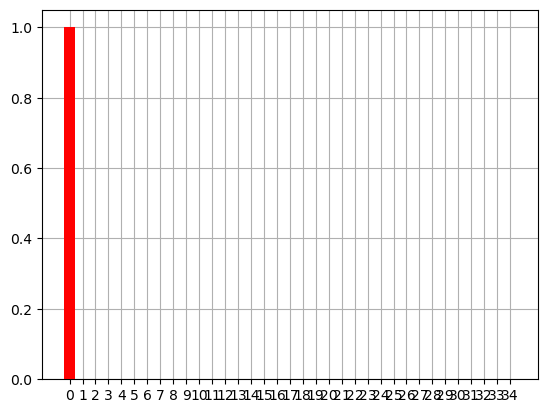

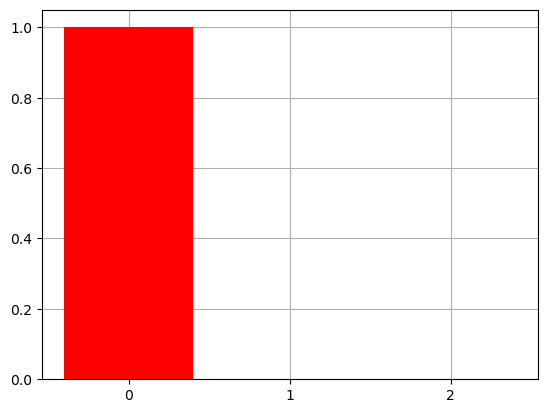

Action at time 7: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 7: (0, 0)
Reward at time 7: 0
[0, 0]


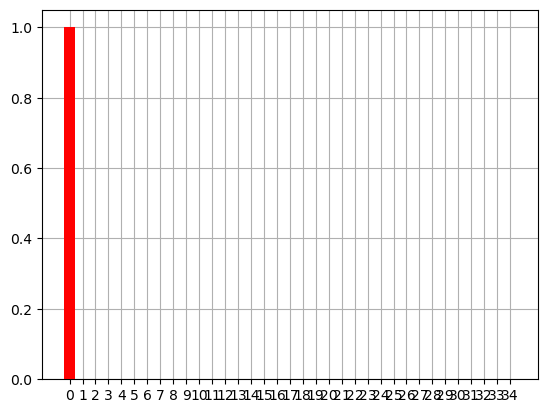

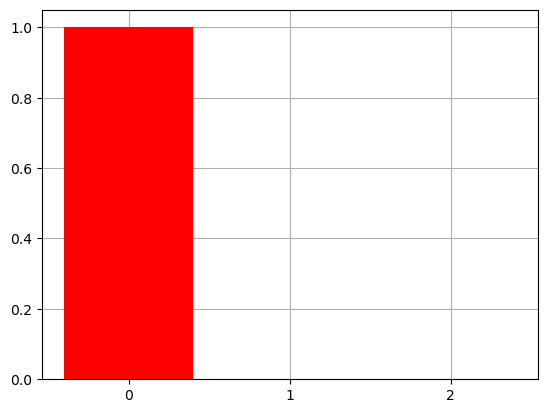

Action at time 8: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 8: (0, 0)
Reward at time 8: 0
[0, 0]


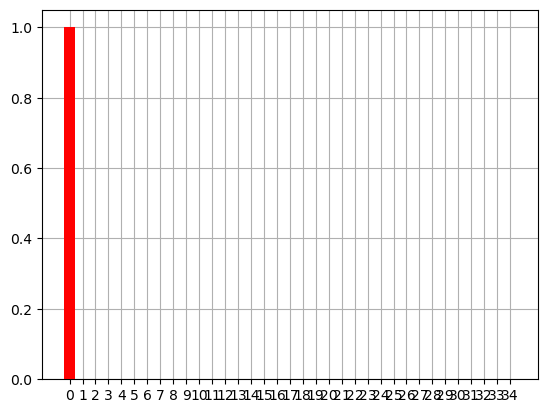

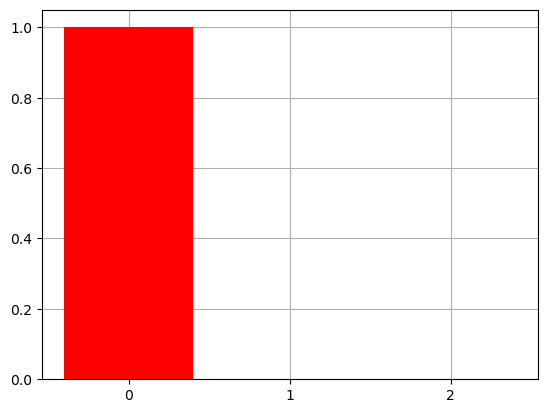

Action at time 9: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 9: (0, 0)
Reward at time 9: 0
[0, 0]


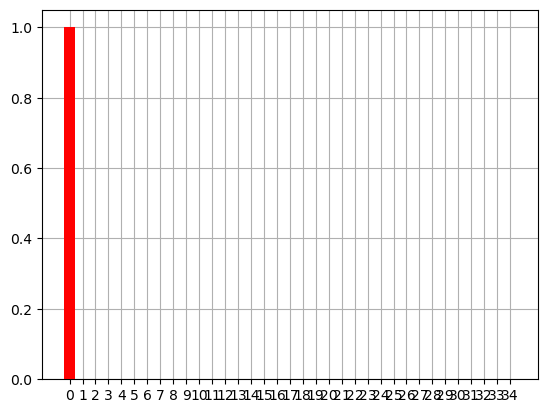

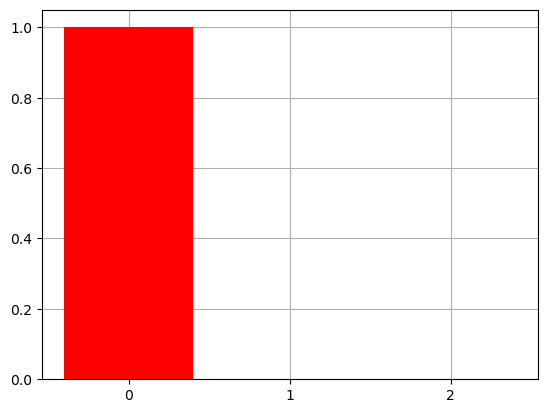

Action at time 10: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 10: (0, 0)
Reward at time 10: 0
[0, 0]


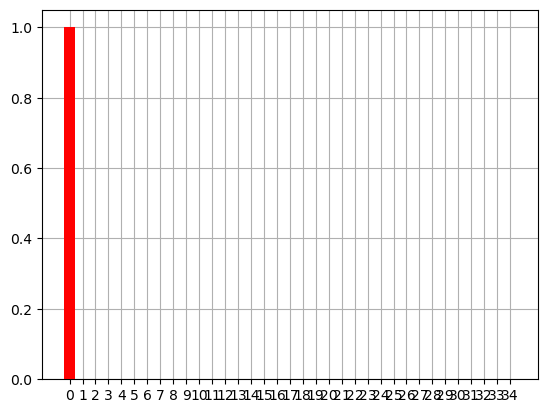

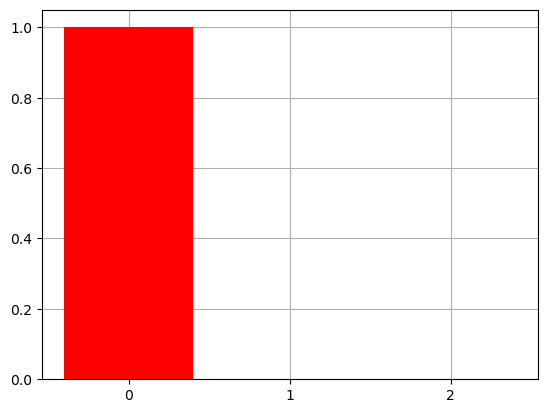

Action at time 11: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 11: (0, 0)
Reward at time 11: 0
[0, 0]


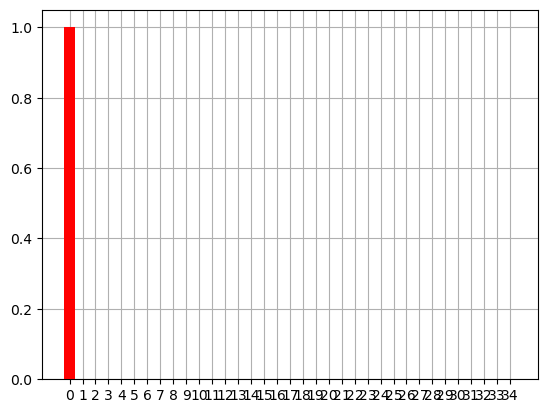

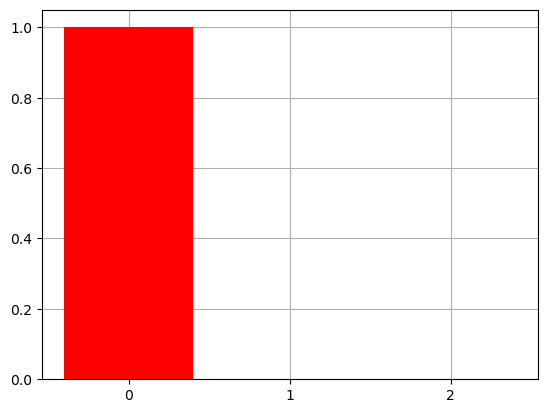

Action at time 12: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 12: (0, 0)
Reward at time 12: 0
[0, 0]


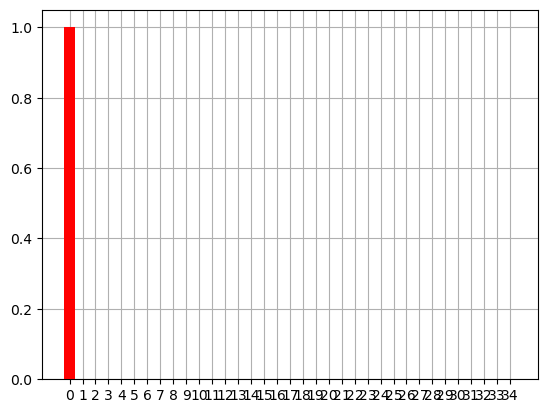

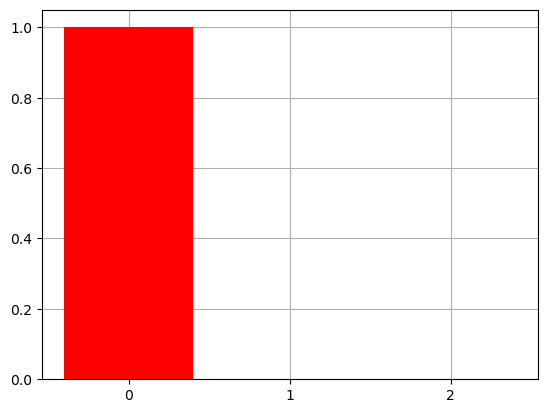

Action at time 13: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 13: (0, 0)
Reward at time 13: 0
[0, 0]


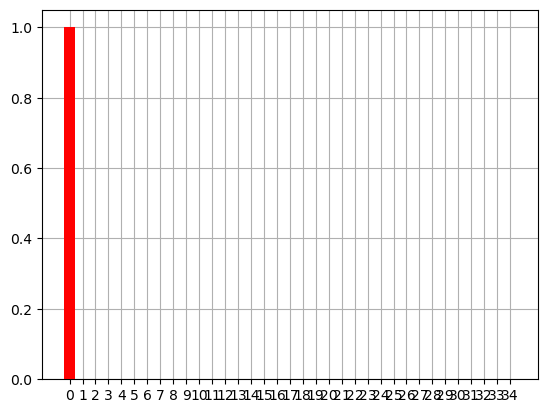

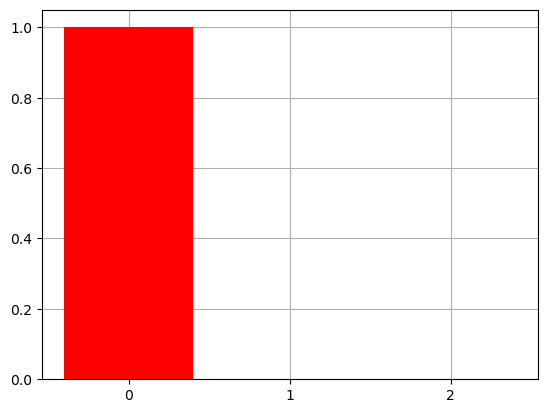

Action at time 14: UP
self.current_location: (0, 0)
0 (0, 0) (6, 4) [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (0, 2), (2, 2), (4, 2), (5, 2), (6, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (0, 4), (1, 4), (2, 4), (3, 4), (5, 4), (0, 0)] [(6, 1), (1, 2), (3, 2), (4, 4)]
Grid location at time 14: (0, 0)
Reward at time 14: 0


In [822]:
history_of_locs = [loc_obs]

T = 15

for t in range(T):

    obs = [grid_locations.index(loc_obs), create_color_observation(loc_obs, red_obs, green_obs, white_obs)]
    print(obs)
    
#     test_obs = [np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#             0]), np.array([1, 0, 0])]
    
    qs = my_agent.infer_states(obs) #directly updates using bayesian inference 

    plot_beliefs(qs[0])
    plot_beliefs(qs[1])

    
    my_agent.infer_policies()
    chosen_action_id = my_agent.sample_action()

    movement_id = int(chosen_action_id[0])

    choice_action = actions[movement_id]

    print(f'Action at time {t}: {choice_action}')

    
    loc_obs, green_obs, white_obs, red_obs, agent_reward = my_env.step(choice_action)
    
    print(agent_reward, loc_obs, green_obs, white_obs, red_obs)


    history_of_locs.append(loc_obs)

    print(f'Grid location at time {t}: {loc_obs}')

    print(f'Reward at time {t}: {agent_reward}')